In [15]:
import numpy as np
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import product
import random
from tqdm import trange

In [16]:
# Set random seed for full reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### Data Loading & Preparation

- **Load** time series from `.mat` file (`Xtrain`)
- **Normalize** values to [0, 1] using `MinMaxScaler` (for stable NN training)
- **Create supervised dataset** for time series forecasting:
  - Convert 1D time series → pairs of:
    - `X`: past `n_steps` values (input window)
    - `y`: next immediate value (target)
  - Example:  
    - Input `[x₀, x₁, ..., xₙ₋₁]` → Target `xₙ`
  - Enables model to learn to predict the next time step from recent history


In [17]:
# Load data
mat = scipy.io.loadmat('Xtrain.mat')
data = mat['Xtrain'].flatten().reshape(-1, 1) #check this

# Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

# Create window sequences
def create_dataset(series, n_steps):
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i + n_steps].flatten())
        y.append(series[i + n_steps])
    return np.array(X), np.array(y)

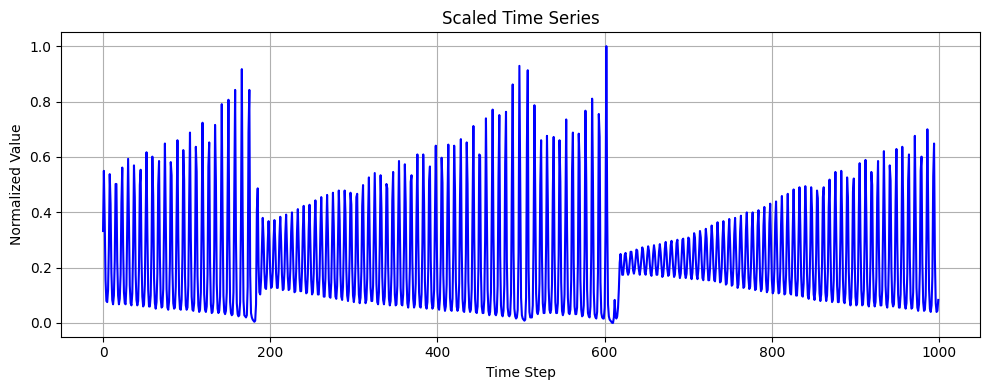

In [18]:
# Plot the scaled data
plt.figure(figsize=(10, 4))
plt.plot(scaled, color='blue')
plt.title('Scaled Time Series')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.grid(True)
plt.tight_layout()
plt.show()

### **Model**

#### Feedforward Neural Network (FFNN) Model

- **Purpose**: Predict the next time step value from `n_steps` past values
- **Architecture**:
  - Input layer: size = `n_steps`
  - Two hidden layers with ReLU activation:
    - Hidden Layer 1: `hidden_sizes[0]`
    - Hidden Layer 2: `hidden_sizes[1]`
  - Output layer: 1 neuron (regression output)
- Built using `nn.Sequential` for clean layer stacking


In [19]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], 1)
        )

    def forward(self, x):
        return self.net(x)

### **Grid Search: Hyperparameter Tuning for FFNN**

This section performs an exhaustive grid search to find the best FFNN configuration based on validation loss.

#### **1. Define Hyperparameter Ranges**
- `n_steps_list`: Different input window sizes (how many past values to use)
- `lrs`: Learning rates to test for the Adam optimizer
- `hidden_size_sets`: Hidden layer sizes (tuples for 2-layer FFNN)

#### **2. Initialize Tracking Variables**
Used to keep track of:
- `best_val_loss`: Best validation loss found so far
- `best_config`: Best hyperparameter combination
- `best_model_state`: Trained weights of the best model
- `best_train_losses`, `best_val_losses`: Loss histories for best model
- `all_results`: Stores results from **every config** tested

#### **3. Loop Over All Combinations of Hyperparameters**
Using `itertools.product()` to try every combination of:
- `n_steps` (input window size)
- `lr` (learning rate)
- `hidden_sizes` (neuron counts in two hidden layers)

#### **4. Prepare Dataset for Each `n_steps`**
- Convert full series into supervised `(X, y)` pairs
- Split into training and validation (80% train / 20% val)
- Convert arrays to PyTorch tensors

#### **5. Initialize Model, Loss, Optimizer**
- Create a new `FeedForwardNN` model for each config
- Use MSE loss for regression
- Adam optimizer with current `lr`

#### **6. Setup Early Stopping**
- Stops training if validation loss doesn't improve after `patience` epochs
- Uses a minimum improvement threshold (`min_delta`)

#### **7. Training Loop (Max 100 Epochs)**
For each epoch:
- Train on full training set
- Evaluate on validation set
- Record losses
- If validation improves:
  - Save current weights and losses
  - Reset patience counter
- Otherwise, increment the no-improvement counter
- Stop early if patience exceeded

#### **8. Store Results for Current Config**
After training:
- Save `val_loss` and hyperparams to `all_results`

#### **9. Track the Best Configuration**
If this model's `val_loss` is better than the best so far:
- Update `best_val_loss`, `best_config`, `best_model_state`
- Save its training and validation loss curves for later analysis


In [ ]:
# --- Training Function ---
def train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor,
                max_epochs=100, patience=5, min_delta=1e-4):
    best_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = criterion(val_pred, y_val_tensor)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if val_loss.item() < best_loss - min_delta:
            best_loss = val_loss.item()
            best_state = model.state_dict()
            best_train = train_losses.copy()
            best_val = val_losses.copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    return best_loss, best_state, best_train, best_val

In [21]:
n_steps_list = [40, 50, 55, 60, 65, 80, 100]
lrs = [0.0005, 0.001, 0.005]
hidden_size_sets = [(32, 16), (64, 32), (128, 64)]

best_val_loss = float('inf')
best_config = None
best_model_state = None
best_train_losses = []
best_val_losses = []
all_results = []

for n_steps, lr, hidden_sizes in product(n_steps_list, lrs, hidden_size_sets):
    print(f"\nTraining with n_steps={n_steps}, lr={lr}, hidden_sizes={hidden_sizes}")

    # Prepare data
    X, y = create_dataset(scaled, n_steps)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, shuffle=True)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # Init model, loss, optimizer
    model = FeedForwardNN(n_steps, hidden_sizes)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train model
    val_loss, state, train_loss_curve, val_loss_curve = train_model(
        model, criterion, optimizer,
        X_train_tensor, y_train_tensor,
        X_val_tensor, y_val_tensor
    )

    # Store result of this config
    all_results.append({
        'n_steps': n_steps,
        'lr': lr,
        'hidden_sizes': hidden_sizes,
        'val_loss': val_loss
    })

    # Save best losses
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_config = (n_steps, lr, hidden_sizes)
        best_model_state = state
        best_train_losses = train_loss_curve
        best_val_losses = val_loss_curve


Training with n_steps=40, lr=0.0005, hidden_sizes=(32, 16)



Training with n_steps=40, lr=0.0005, hidden_sizes=(64, 32)



Training with n_steps=40, lr=0.0005, hidden_sizes=(128, 64)



Training with n_steps=40, lr=0.001, hidden_sizes=(32, 16)



Training with n_steps=40, lr=0.001, hidden_sizes=(64, 32)



Training with n_steps=40, lr=0.001, hidden_sizes=(128, 64)



Training with n_steps=40, lr=0.005, hidden_sizes=(32, 16)



Training with n_steps=40, lr=0.005, hidden_sizes=(64, 32)



Training with n_steps=40, lr=0.005, hidden_sizes=(128, 64)



Training with n_steps=50, lr=0.0005, hidden_sizes=(32, 16)



Training with n_steps=50, lr=0.0005, hidden_sizes=(64, 32)



Training with n_steps=50, lr=0.0005, hidden_sizes=(128, 64)



Training with n_steps=50, lr=0.001, hidden_sizes=(32, 16)



Training with n_steps=50, lr=0.001, hidden_sizes=(64, 32)



Training with n_steps=50, lr=0.001, hidden_sizes=(128, 64)



Training with n_steps=50, lr=0.005, hidden_sizes=(32, 16)



Training with n_steps=50, lr=0.005, hidden_sizes=(64, 32)



Training with n_steps=50, lr=0.005, hidden_sizes=(128, 64)



Training with n_steps=55, lr=0.0005, hidden_sizes=(32, 16)



Training with n_steps=55, lr=0.0005, hidden_sizes=(64, 32)



Training with n_steps=55, lr=0.0005, hidden_sizes=(128, 64)



Training with n_steps=55, lr=0.001, hidden_sizes=(32, 16)



Training with n_steps=55, lr=0.001, hidden_sizes=(64, 32)



Training with n_steps=55, lr=0.001, hidden_sizes=(128, 64)



Training with n_steps=55, lr=0.005, hidden_sizes=(32, 16)



Training with n_steps=55, lr=0.005, hidden_sizes=(64, 32)



Training with n_steps=55, lr=0.005, hidden_sizes=(128, 64)



Training with n_steps=60, lr=0.0005, hidden_sizes=(32, 16)



Training with n_steps=60, lr=0.0005, hidden_sizes=(64, 32)



Training with n_steps=60, lr=0.0005, hidden_sizes=(128, 64)



Training with n_steps=60, lr=0.001, hidden_sizes=(32, 16)



Training with n_steps=60, lr=0.001, hidden_sizes=(64, 32)



Training with n_steps=60, lr=0.001, hidden_sizes=(128, 64)



Training with n_steps=60, lr=0.005, hidden_sizes=(32, 16)



Training with n_steps=60, lr=0.005, hidden_sizes=(64, 32)



Training with n_steps=60, lr=0.005, hidden_sizes=(128, 64)



Training with n_steps=65, lr=0.0005, hidden_sizes=(32, 16)



Training with n_steps=65, lr=0.0005, hidden_sizes=(64, 32)



Training with n_steps=65, lr=0.0005, hidden_sizes=(128, 64)



Training with n_steps=65, lr=0.001, hidden_sizes=(32, 16)



Training with n_steps=65, lr=0.001, hidden_sizes=(64, 32)



Training with n_steps=65, lr=0.001, hidden_sizes=(128, 64)



Training with n_steps=65, lr=0.005, hidden_sizes=(32, 16)



Training with n_steps=65, lr=0.005, hidden_sizes=(64, 32)



Training with n_steps=65, lr=0.005, hidden_sizes=(128, 64)



Training with n_steps=80, lr=0.0005, hidden_sizes=(32, 16)



Training with n_steps=80, lr=0.0005, hidden_sizes=(64, 32)



Training with n_steps=80, lr=0.0005, hidden_sizes=(128, 64)



Training with n_steps=80, lr=0.001, hidden_sizes=(32, 16)



Training with n_steps=80, lr=0.001, hidden_sizes=(64, 32)



Training with n_steps=80, lr=0.001, hidden_sizes=(128, 64)



Training with n_steps=80, lr=0.005, hidden_sizes=(32, 16)



Training with n_steps=80, lr=0.005, hidden_sizes=(64, 32)



Training with n_steps=80, lr=0.005, hidden_sizes=(128, 64)



Training with n_steps=100, lr=0.0005, hidden_sizes=(32, 16)



Training with n_steps=100, lr=0.0005, hidden_sizes=(64, 32)



Training with n_steps=100, lr=0.0005, hidden_sizes=(128, 64)



Training with n_steps=100, lr=0.001, hidden_sizes=(32, 16)



Training with n_steps=100, lr=0.001, hidden_sizes=(64, 32)



Training with n_steps=100, lr=0.001, hidden_sizes=(128, 64)



Training with n_steps=100, lr=0.005, hidden_sizes=(32, 16)



Training with n_steps=100, lr=0.005, hidden_sizes=(64, 32)



Training with n_steps=100, lr=0.005, hidden_sizes=(128, 64)


In [22]:
# ---- Final result ----
print("\nBest Model Found:")
print(f"n_steps={best_config[0]}, lr={best_config[1]}, hidden_sizes={best_config[2]}")
print(f"Validation Loss: {best_val_loss:.6f}")

# Load best model
best_model = FeedForwardNN(best_config[0], best_config[2])
best_model.load_state_dict(best_model_state)
best_model.eval()


Best Model Found:
n_steps=40, lr=0.001, hidden_sizes=(128, 64)
Validation Loss: 0.002091


FeedForwardNN(
  (net): Sequential(
    (0): Linear(in_features=40, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [23]:
df_results = pd.DataFrame(all_results)
df_results['params'] = df_results.apply(
    lambda row: f"n={row['n_steps']}, lr={row['lr']}, h={row['hidden_sizes']}", axis=1
)

# Print sorted results
print("\nAll Config Results (sorted):")
print(df_results.sort_values("val_loss"))


All Config Results (sorted):
    n_steps      lr hidden_sizes  val_loss                        params
5        40  0.0010    (128, 64)  0.002091   n=40, lr=0.001, h=(128, 64)
17       50  0.0050    (128, 64)  0.002708   n=50, lr=0.005, h=(128, 64)
25       55  0.0050     (64, 32)  0.002872    n=55, lr=0.005, h=(64, 32)
44       65  0.0050    (128, 64)  0.003898   n=65, lr=0.005, h=(128, 64)
3        40  0.0010     (32, 16)  0.004015    n=40, lr=0.001, h=(32, 16)
..      ...     ...          ...       ...                           ...
50       80  0.0010    (128, 64)  0.034425   n=80, lr=0.001, h=(128, 64)
15       50  0.0050     (32, 16)  0.035738    n=50, lr=0.005, h=(32, 16)
39       65  0.0010     (32, 16)  0.037880    n=65, lr=0.001, h=(32, 16)
55      100  0.0005     (64, 32)  0.038513  n=100, lr=0.0005, h=(64, 32)
58      100  0.0010     (64, 32)  0.040139   n=100, lr=0.001, h=(64, 32)

[63 rows x 5 columns]


### Visualizing Model Performance

This section includes two plots to help evaluate and understand model performance across different configurations.


#### 1. Best Model Loss Evolution (per Epoch)
`plot_best_model_loss(train_losses, val_losses)`

- Plots the **training** and **validation loss curves** for the best-performing model.
- Helps visualize:
  - How quickly the model learns
  - When (or if) overfitting starts
  - Whether early stopping was triggered

#### 2. Bar Plot: Validation Loss vs `n_steps` (Best Config Only)
`bar_plot_val_loss_vs_n_steps_best_config(all_results)`

- Compares **validation loss** across different `n_steps` (input window sizes)
- Filters only results where:
  - Learning rate (`lr`) and hidden layer sizes match the **best configuration**
- Useful to:
  - Understand how sequence length impacts model performance
  - Identify the optimal input window size


In [24]:
# Plot 1: Best Model Loss Evolution Through Epochs
def plot_best_model_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Best Model Loss Evolution Through Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Plot 2: Bar Plot of Validation Loss vs n_steps for Best Config
def bar_plot_val_loss_vs_n_steps_best_config(all_results):
    df = pd.DataFrame(all_results)

    # Find the best overall config (lowest validation loss)
    best_row = df.loc[df['val_loss'].idxmin()]
    best_lr = best_row['lr']
    best_hidden = best_row['hidden_sizes']

    # Filter to only rows with best lr and hidden sizes
    filtered_df = df[(df['lr'] == best_lr) & (df['hidden_sizes'] == best_hidden)]
    filtered_df = filtered_df.sort_values(by='n_steps')

    # Plot
    plt.figure(figsize=(10, 5))
    bars = plt.bar(filtered_df['n_steps'].astype(str), filtered_df['val_loss'])
    plt.xlabel('n_steps')
    plt.ylabel('Validation Loss')
    plt.title(f'Validation Loss by n_steps (best config: lr={best_lr}, h={best_hidden})')
    plt.grid(axis='y')

    # Annotate bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', 
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    

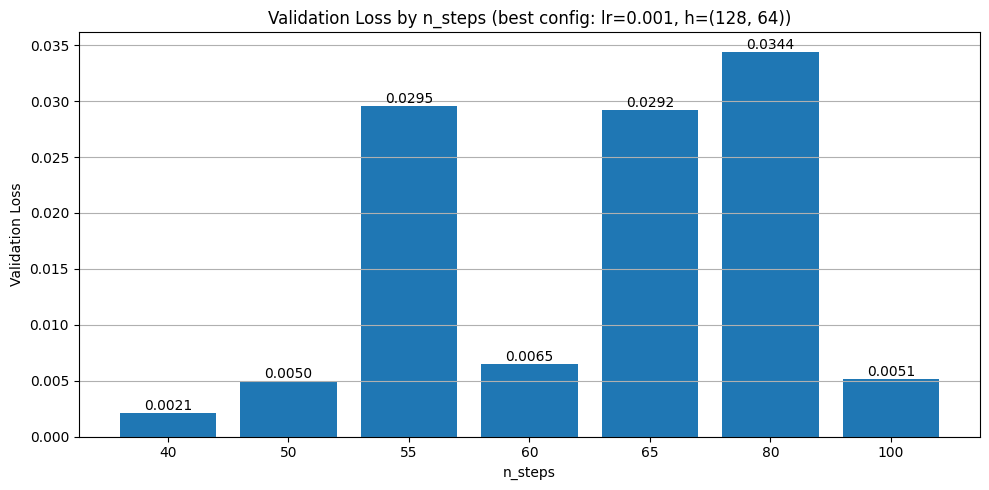

In [25]:
# Call after your search
bar_plot_val_loss_vs_n_steps_best_config(all_results)

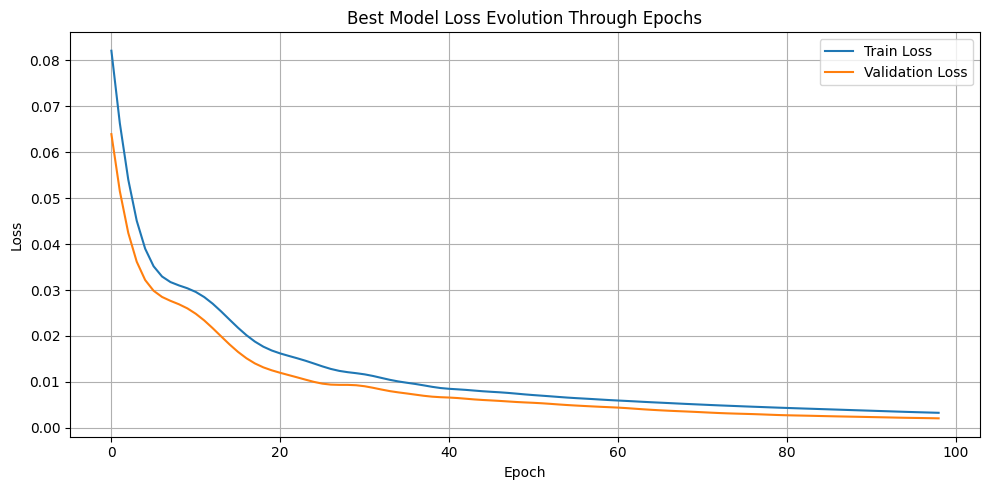

In [26]:
plot_best_model_loss(best_train_losses, best_val_losses)

### Forecasting the Validation Set

This step evaluates how well the trained model performs on the validation data by comparing its predictions to the actual ground truth.


#### Function: `forecast_validation(model, X_val, scaler)`
- Runs the model on the validation input (`X_val`)
- Uses `torch.no_grad()` to disable gradient tracking (faster, saves memory)
- Converts model predictions and ground truth from **scaled** to **original values** using the fitted `scaler`

#### Plot: Predicted vs Actual Validation Values
- Compares **predicted values** against the **true validation targets**
- Helps visually assess the model's accuracy and lag/overshoot tendencies


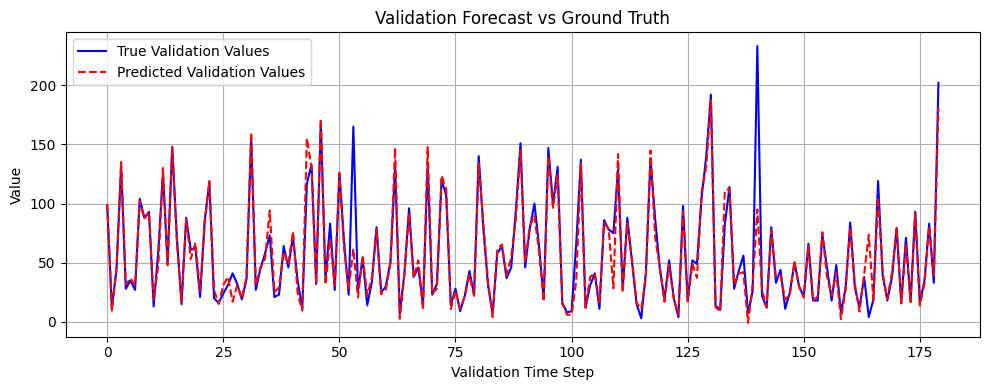

In [27]:
def forecast_validation(model, X_val, scaler):
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        preds = model(X_val_tensor).numpy()

    # Inverse scale predictions and actual values
    preds_rescaled = scaler.inverse_transform(preds)
    y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1))
    return preds_rescaled.flatten(), y_val_rescaled.flatten()

# Forecast on validation set
val_predictions, val_true = forecast_validation(model, X_val, scaler)

# Plot predictions vs true values
plt.figure(figsize=(10, 4))
plt.plot(val_true, label='True Validation Values', color='blue')
plt.plot(val_predictions, label='Predicted Validation Values', color='red', linestyle='--')
plt.title('Validation Forecast vs Ground Truth')
plt.xlabel('Validation Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
# ----  Recursive Forecasting Function ----

def recursive_forecast(model, seed_seq, n_future, scaler):
    model.eval()
    forecast = []
    input_seq = seed_seq.copy()

    for _ in range(n_future):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).view(1, -1)
        with torch.no_grad():
            next_val = model(input_tensor).item()
        forecast.append(next_val)
        input_seq = input_seq[1:] + [next_val]  # Slide the window

    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast.flatten()

### Recursive Forecasting (Autoregressive Prediction)

This function generates **multi-step forecasts** by feeding the model's own predictions back as inputs — one step at a time.


#### Function: `recursive_forecast(model, seed_seq, n_future, scaler)`
- **Inputs**:
  - `model`: trained PyTorch model
  - `seed_seq`: initial window (last `n_steps` real values)
  - `n_future`: number of future time steps to predict
  - `scaler`: used to inverse-transform the forecasted values
- **Process**:
  - Loop `n_future` times:
    - Predict the next value from current `input_seq`
    - Append prediction to the forecast list
    - Slide window: drop oldest value, add new prediction
- **Output**:
  - Returns the full forecast in the **original (unscaled) value range**

Ideal for simulating future behavior beyond the known dataset.


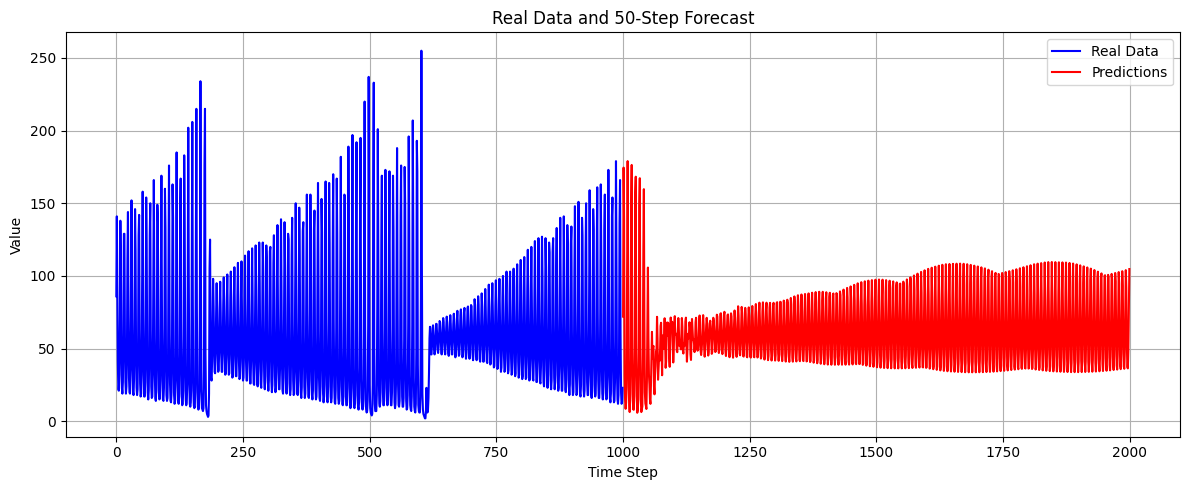

In [29]:
# Use the last real window as seed
last_window = scaled[-n_steps:].flatten().tolist()
future_preds = recursive_forecast(model, last_window, n_future=1000, scaler=scaler)

# Inverse transform the full scaled dataset back to original scale for plotting
real_data = scaler.inverse_transform(scaled)

# Create an array combining the original data with predictions
extended = np.concatenate((real_data.flatten(), future_preds))

# Create time axis
time_axis = np.arange(len(extended))
real_axis = np.arange(len(real_data))
pred_axis = np.arange(len(real_data), len(extended))

# Plot
plt.figure(figsize=(12, 5))
#plt.plot(time_axis, extended, label='Extended (Real + Predicted)', linestyle='--', color='gray')
plt.plot(real_axis, real_data, label='Real Data', color='blue')
plt.plot(pred_axis, future_preds, label='Predictions', color='red')
plt.title('Real Data and 50-Step Forecast')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()